This is a quick demo of tracking code adapted from [Ramot et al. 2008](https://https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002208) to track freely moving fish. 

It ultilizes the Canny segmentation from the [segmentation notebook](https://github.com/mochiliu/salmon-demo/blob/main/segmentation.ipynb). Unfortunately, the segmentation is not that great to showcase the tracking, but here it is anyway.

In [ ]:
import numpy as np
import cv2 as cv
from skimage.morphology import erosion, dilation, opening, closing, flood_fill, square, remove_small_objects
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.draw import line
from scipy import ndimage
from matplotlib import pyplot as plt
import os
from google.colab import drive
import random as rng

Declare constants:

In [ ]:
MAX_DISTANCE_BETWEEN_FRAMES = 20 #pixels
MAX_SIZE_CHANGE_BETWEEN_FRAMES = 1000 #pixels

Load google drive. Authentication is required for the first time.

In [ ]:
drive_path = '/content/drive'
image_path = drive_path + '/MyDrive/Colab Notebooks/BergenFrames'
save_path = drive_path + '/MyDrive/Colab Notebooks/OutputFrames'
drive.mount(drive_path)
imgs = os.listdir(image_path)
imgs.sort()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The following function is explored in more detail at the segmentation notebook

In [ ]:
def image_segment(img):
  # quick and dirty segmentation
  img = cv.blur(img, (3,3))
  edges = cv.Canny(img,15,60)
  morph_edges = closing(edges,square(7))  #close to connect disjoined lines
  morph_edges = ndimage.binary_fill_holes(morph_edges) #fill in the fish
  morph_edges = opening(morph_edges,square(7)) # remove spurious lines
  morph_edges = remove_small_objects(morph_edges,min_size = 150) # remove objects that are too small
  morph_edges = np.uint8(morph_edges)
  return morph_edges

Begin tracking:

/content/drive/MyDrive/Colab Notebooks/OutputFrames/000001.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000002.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000003.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000004.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000005.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000006.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000007.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000008.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000009.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000010.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000011.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000012.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000013.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000014.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000015.png
/content/drive/MyDrive/Colab Notebooks/OutputFrames/000

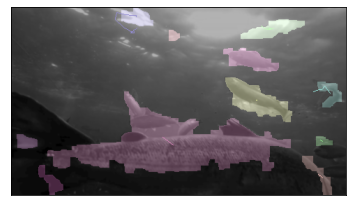

In [ ]:
active_tracks = []
completed_tracks = []

frame_index = 0
for frame_name in imgs:
  #read in frame
  single_img_path = image_path + '/' + frame_name
  cur_img = cv.imread(single_img_path,0)

  #downsample from 1080p
  img = cv.pyrDown(cur_img)
  img = cv.pyrDown(img)

  #segment
  binary_particle_image = image_segment(img)

  #label and get regionprops
  label_img = label(binary_particle_image, connectivity=img.ndim)
  props = regionprops(label_img)

  #prepare regionprops to match to tracks
  fish_coordinates = np.zeros((len(props),2))
  fish_sizes = []
  particle_indecies = []
  region_index = 0
  for prop in props:
    fish_coordinates[region_index,:] = prop.centroid
    fish_sizes.append(prop.area)
    particle_indecies.append(prop.label)
    region_index += 1

  # Update active tracks with new coordinates
  active_track_indecies_to_end = []
  for active_track_index in range(len(active_tracks)):
    # For each active track, find the closest particle
    if len(fish_coordinates) > 0:
      distanceX = fish_coordinates[:,0] - active_tracks[active_track_index]['Path'][-1][0];
      distanceY = fish_coordinates[:,1] - active_tracks[active_track_index]['Path'][-1][1];
      distances = np.sqrt(np.square(distanceX) + np.square(distanceY));
      min_index = np.argmin(distances)
      min_distance = np.min(distances)

      #calculate change in size
      fish_size = fish_sizes[min_index]
      last_fish_size = active_tracks[active_track_index]['Size'][-1]
      size_difference = np.absolute(fish_size - last_fish_size)

      if min_distance <= MAX_DISTANCE_BETWEEN_FRAMES and size_difference <= MAX_SIZE_CHANGE_BETWEEN_FRAMES:
        #criteria satisfied, continue track
        active_tracks[active_track_index]['Path'].append(fish_coordinates[min_index,:])
        active_tracks[active_track_index]['Frames'].append(frame_index)
        active_tracks[active_track_index]['Size'].append(fish_sizes.pop(min_index))
        active_tracks[active_track_index]['ParticleLabel'].append(particle_indecies.pop(min_index))
        fish_coordinates = np.delete(fish_coordinates,min_index,axis=0)
      else:
        #mark the track end
        active_track_indecies_to_end.insert(0,active_track_index)
    
  #end tracks
  for active_track_index in active_track_indecies_to_end:
    completed_tracks.append(active_tracks.pop(active_track_index))

  #start new tracks
  for new_active_track_index in range(len(fish_sizes)):
    active_tracks.append({'Path':[fish_coordinates[new_active_track_index,:]], 
                          'Frames':[frame_index], 
                          'Size':[fish_sizes[new_active_track_index]], 
                          'ParticleLabel':[particle_indecies[new_active_track_index]],
                          'Color':(rng.uniform(0.5,1), rng.uniform(0.5,1), rng.uniform(0.5,1))})

  #plot labeled image
  particle_colors = [(0,0,0) for i in range(len(active_tracks)+1)] #make a list of colors
  for active_track in active_tracks:
    particle_colors[active_track['ParticleLabel'][-1]] = active_track['Color']
  drawing = label2rgb(label_img, image=img, colors=particle_colors)
  
  #plot tracked line
  for active_track in active_tracks:
    for tracked_frame_index in range(len(active_track['Path'])-1):
      intpath1 = active_track['Path'][tracked_frame_index].astype(int)
      intpath2 = active_track['Path'][tracked_frame_index+1].astype(int)
      rr, cc = line(intpath1[0], intpath1[1], intpath2[0], intpath2[1])
      drawing[rr, cc, :] = active_track['Color']

  #save the image
  plt.imshow(drawing), plt.xticks([]), plt.yticks([])
  plt.savefig(save_path + '/' + f'{frame_index:06}' + '.png')

  frame_index += 1
  print(save_path + '/' + f'{frame_index:06}' + '.png')

# move all tracks to completion
for active_track in active_tracks:
  completed_tracks.append(active_track)
print(completed_tracks)

Disconnect google:

In [ ]:
drive.flush_and_unmount()